# Projeto 1 

## 1 - Definição do problema de negócio 

Queremos prever qual é o **risco de crédito de um dado cliente**, ou seja, se ele será um **bom** ou **mau** pagador, com base em um conjunto de dados históricos contendo algumas características dos clientes (as variáveis preditoras) e se esses clientes foram bons ou maus pagadores, no passado.

Fonte dos dados: https://www.kaggle.com/uciml/german-credit

## 2 - Pré-processamento dos dados 

Nesta estapa iremos realizar a **análise exploratória** e uma **pré-preparação** dos dados para modelagem preditiva. 

In [35]:
### 2.1 - Análise exploratória import pandas as pd 
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## Imputar valores 
from sklearn.impute import SimpleImputer

## Codificação numérica as variáveis qualitativas
from sklearn.preprocessing import OneHotEncoder

## Normalização/Padronização 
from sklearn.preprocessing import MinMaxScaler, StandardScaler

## Balanceamento de classes 
from imblearn.over_sampling import SMOTE 

## Divisão treino/teste 
from sklearn.model_selection import train_test_split
# Cross Validation 
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

## Pipelines 
from imblearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer 

## Tratamento de outliers 
from sklearn.neighbors import LocalOutlierFactor

## Métricas de avaliação. 
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score 

## Algoritmos de aprendizagem. 
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier)

## Otimização 
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings("ignore")

### 2.1 - Análise exploratória 

In [2]:
df = pd.read_csv('dados/german_credit_data.csv')
print("Nº de observações: %d" % (df.shape[0]))
print("Nº de variáveis: %d" % (df.shape[1]))
df.head()

Nº de observações: 1000
Nº de variáveis: 11


,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,2,49,male,1,own,little,NaN,2096,12,education,good
3,3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,4,53,male,2,free,little,little,4870,24,car,bad


Removeremos a coluna **Unnamed: 0** por se tratar de um índice das observações do dataframe. 

In [3]:
del df['Unnamed: 0']
df.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,49,male,1,own,little,NaN,2096,12,education,good
3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,53,male,2,free,little,little,4870,24,car,bad


#### Variáveis do conjunto de dados

    Age (numeric)

    Sex (text: male, female)

    Job (numeric: 0 - unskilled and non-resident, 1 - unskilled and resident, 2 - skilled, 3 - highly skilled)

    Housing (text: own, rent, or free)

    Saving accounts (text - little, moderate, quite rich, rich)

    Checking account (numeric, in DM - Deutsch Mark)

    Credit amount (numeric, in DM)

    Duration (numeric, in month)

    Purpose(text: car, furniture/equipment, radio/TV, domestic appliances, repairs, education, business, vacation/others) 

    => Risk (Value target - Good or Bad Risk)

In [4]:
# Variáveis preditoras. 

var_predit = ['Age', 'Sex', 'Job', 'Housing', 'Saving accounts', 'Checking account', 'Credit amount', 'Duration', 'Purpose']

In [5]:
# Verificando o tipo de dados das variáveis. 

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               1000 non-null   int64 
 1   Sex               1000 non-null   object
 2   Job               1000 non-null   int64 
 3   Housing           1000 non-null   object
 4   Saving accounts   817 non-null    object
 5   Checking account  606 non-null    object
 6   Credit amount     1000 non-null   int64 
 7   Duration          1000 non-null   int64 
 8   Purpose           1000 non-null   object
 9   Risk              1000 non-null   object
dtypes: int64(4), object(6)
memory usage: 78.2+ KB


#### Verificando valores missing

Valores missing (valores perdidos) ou valores **NaN** (Not Avaiable Number) são valores faltantes em uma ou mais colunas. Eles devem ser tratados de alguma maneira para evitar problemas na modelagem preditiva.

In [6]:
df_missing = pd.DataFrame(df.isna().sum()[df.isna().sum() != 0].sort_values(ascending = False), columns = ["qtd_nan"])
df_missing['porcentagem'] = round(df_missing['qtd_nan']*100/len(df),1)
df_missing

,qtd_nan,porcentagem
Checking account,394,39.4
Saving accounts,183,18.3


Observe que quase **40%** dos dados da variável **Checking account** são valores ausentes, da mesma maneira cerca de **18%** dos dados da variável **Saving accounts**. 

#### Verificando o tipo das variáveis

Identificaremos quais das variáveis são **quantitativas/numéricas** ou **qualitativas/categóricas**. Além disso iremos verificar se alguma das variáveis quantitativas podem ser uma variável do tipo qualitativa, ou seja, a variável possui elementos numéricos discretos que representam informação qualitativa. 

In [7]:
# Verificando valores únicos - poucos valores únicos (<~20) indicam uma grande chance de variável qualitativa/categórica.
df.nunique()

Age                  53
Sex                   2
Job                   4
Housing               3
Saving accounts       4
Checking account      3
Credit amount       921
Duration             33
Purpose               8
Risk                  2
dtype: int64

In [8]:
df.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,49,male,1,own,little,NaN,2096,12,education,good
3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,53,male,2,free,little,little,4870,24,car,bad


Observando o dataframe e o resumo de valores únicos, podemos determinar a lista de variáveis quantitativas e qualitativas. 

In [9]:
# Variáveis quantitativas
qt = ['Age', 'Credit amount', 'Duration']

# Variáveis quanlitativas
ql = ['Sex', 'Job', 'Housing', 'Saving accounts', 'Checking account', 'Purpose', 'Risk']

#### Variável alvo 

In [10]:
print("A variável alvo possui %d classes, as classes são %s." % (len(set(df['Risk'])), set(df['Risk']))) 

A variável alvo possui 2 classes, as classes são {'bad', 'good'}.


A variável alvo possui **classes desbalanceadas**, ou seja, há muito mais bons pagadores do que maus neste conjunto de dados. Esse tipo de desequilíbrio pode levar a um modelo tendencioso e impreciso. 

In [11]:
good = df[df['Risk'] == 'good'].shape[0]*100/df.shape[0]
bad = 100 - good   

print(" Cerca de %.1f %% dos dados pertencem a classe '%s'." %(good,'good'))
print(" Cerca de %.1f %% dos dados pertencem a classe '%s'." %(bad,'bad'))

 Cerca de 70.0 % dos dados pertencem a classe 'good'.
 Cerca de 30.0 % dos dados pertencem a classe 'bad'.


Podemos atribuir uma codificação numérica a variável alvo, ou seja, para 'good' atribuiremos o valor 1 e para 'bad' o valor 0. 

In [12]:
df['Risk'] = np.where(df['Risk'] == 'bad', 0, 1)
df.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,1
1,22,female,2,own,little,moderate,5951,48,radio/TV,0
2,49,male,1,own,little,NaN,2096,12,education,1
3,45,male,2,free,little,little,7882,42,furniture/equipment,1
4,53,male,2,free,little,little,4870,24,car,0


#### 2.1.1 - Análise estatística das variáveis quantitativas

In [13]:
# Dimensões 
print("Nº de observações: %d" % (df[qt].shape[0]))
print("Nº de variáveis: %d" % (df[qt].shape[1]))
df[qt].head()

Nº de observações: 1000
Nº de variáveis: 3


,Age,Credit amount,Duration
0,67,1169,6
1,22,5951,48
2,49,2096,12
3,45,7882,42
4,53,4870,24


In [14]:
# Resumo estatístico básico 

df[qt].describe().round(1).T

,count,mean,std,min,25%,50%,75%,max
Age,1000.0,35.5,11.4,19.0,27.0,33.0,42.0,75.0
Credit amount,1000.0,3271.3,2822.7,250.0,1365.5,2319.5,3972.2,18424.0
Duration,1000.0,20.9,12.1,4.0,12.0,18.0,24.0,72.0


In [15]:
# Medida de correlção entre as variáveis

df[qt].corr(method = 'pearson').round(3)

,Age,Credit amount,Duration
Age,1.000,0.033,-0.036
Credit amount,0.033,1.000,0.625
Duration,-0.036,0.625,1.000


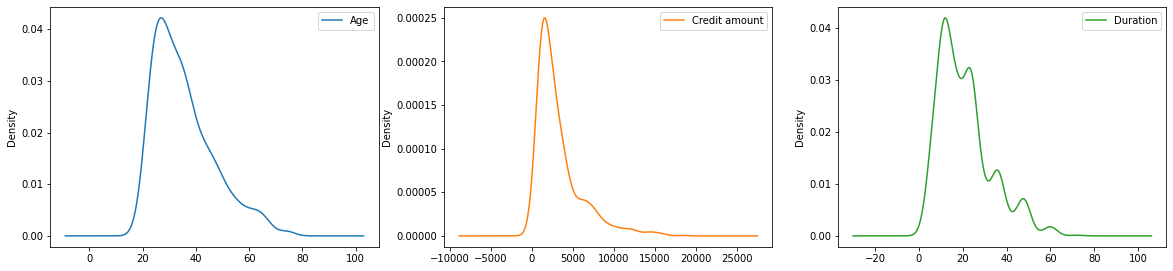

In [16]:
# O density plot facilita a visualização da distribuição dos dados.

df[qt].plot(kind = 'density', figsize = (20,15), layout = (3, 3), subplots = True, sharex = False)
plt.show()

In [17]:
# Assimetria 
pd.DataFrame(df[qt].skew() , columns = ['Assimetria']) 

,Assimetria
Age,1.020739
Credit amount,1.949628
Duration,1.094184


In [18]:
# Curtose
pd.DataFrame(df[qt].kurt() , columns = ['Curtose']) 

,Curtose
Age,0.595780
Credit amount,4.292590
Duration,0.919781


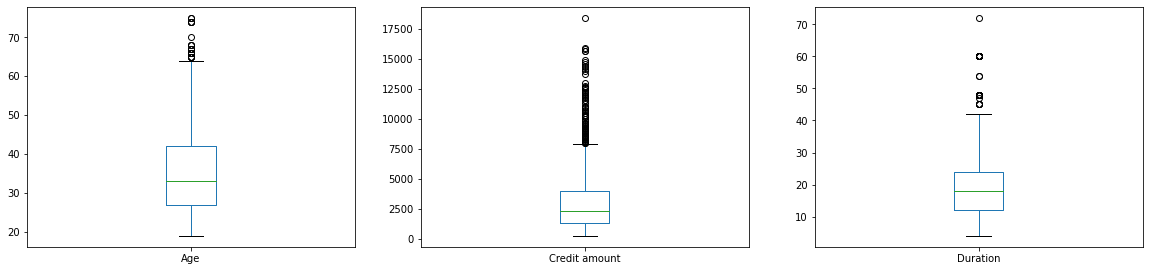

In [19]:
# Verificando outliers 

df[qt].plot(kind = 'box', figsize = (20,15), layout = (3, 3), subplots = True, sharex = False)
plt.show()

#### Conclusão parcial 

Com base na análise exploratória e nas medidas estatísticas de **tendência central**, **dispersão**, **forma** e de **correlação** e na análise dos gráficos de **distribuição** e **boxplots** , notamos que:

    I)  Cerca 40% dos dados da variável Checking account e 18% dos dados da variável Saving accounts são valores ausentes. 
    
    II) Há 3 variáveis quantitativas: 'Age', 'Credit amount' e 'Duration'
        Há 7 variáveis quantitativas: 'Sex', 'Job', 'Housing', 'Saving accounts', 'Checking account', 'Purpose' e a variável alvo 'Risk' 
    
    III) Outliers deverão ser tratados nas variáveis quantitativas. 
    
    IV) Não há problemas de alta correlação entre as variáveis quantitativas.  
    
    V) A variável alvo possui classes desbalanceadas, 70.0 % dos dados pertencem a classe 'good' e 30.0 % dos dados pertencem a classe 'bad'.

## 3 - Etapa de processamento dos dados

Nesta etapa faremos o **tratamento dos dados**, **seleção de variáveis**, **seleção de algoritmos**, **seleção de modelos de aprendizagem**, **seleção de métricas de avaliação** e aplicaremos técnicas de amostragem para estabelecer a divisão dos **dados de treino** e **dados de teste** dos algoritmos.

### 3.1) Seleção de métricas de avaliação 

Para avaliação de todos os modelos utilizaremos as três métricas descritas abaixo, um modelo que tiver avaliações melhores em **duas ou mais** métricas será o escolhido, em todas as comparações realizadas. Para medir o desempenho dos algoritmos e seus modelos, utilizaremos as seguintes métricas de avaliação: 
    
**Acurácia**: é a métrica mais geral dos classificadores, basicamente **N° total de acertos/N° total de classificações**, fornece uma avaliação genérica, mas facilmente interpretável. Quanto mais próxima de 1 **melhor** é o modelo. 

**F1-score**: utiliza a média harmônica das métricas Precisão e Recall, garantindo assim a consideração dos falsos positivos e negativos, quanto mais próxima de 1 **melhor** é o modelo.

**ROC**: 

In [20]:
# Função para aplicar as métricas.

def metricas(y_teste, y_pred):
    print("Acurácia = %.2f" % (accuracy_score(y_teste, y_pred)))
    print("f1_score = %.2f" % (f1_score(y_teste, y_pred)))
    print("ROC = %.2f" % (roc_auc_score(y_teste, y_pred)))
       
def valores_metricas(y_teste, y_pred):
    acc = accuracy_score(y_teste, y_pred)
    f1 = f1_score(y_teste, y_pred)
    roc = roc_auc_score(y_teste, y_pred)
    return [acc, f1, roc]

### 3.2) Seleção do algoritmo de aprendizagem. 

#### 3.2.1 - Divisão dados de treino e teste.

In [21]:
X = df[var_predit]
Y = df['Risk']
x_treino, x_teste, y_treino, y_teste = train_test_split(X, Y, test_size = 0.30, random_state = 5)

Utilizaremos o framework **make_pipeline** e **ColumnTransformer** para organizar e facilitar nosso trabalho. Além disso utilizaremos os seguintes pacotes:  

**OneHotEncoder()**: realiza a codificação numérica das variáveis categóricas. 

**SimpleImputer()**: substitui os valores missing seguindo um critério escolhido. 

**MinMaxScaler()**: processo de normalização dos dados, fundamental para classificadores que utilizam medidas de distância. 

#### Seleção de algoritmo

Testaremos diversos algoritmos de aprendizado de máquina e avaliaremos os modelos preditivos criados por eles utilizando os dados de treino, então avaliaremos esses modelos utilizando os dados de teste + métricas definadas acima.

In [22]:
def selec_model(x_treino, x_teste, y_treino, y_teste):
    
    qt = ['Age', 'Credit amount', 'Duration']
    ql = ['Sex', 'Job', 'Housing', 'Saving accounts', 'Checking account', 'Purpose']
    
    modelos = []
    modelos.append(('LR', LogisticRegression()))
    modelos.append(('KNN', KNeighborsClassifier()))
    modelos.append(('GNB', GaussianNB()))
    modelos.append(('LDA', LinearDiscriminantAnalysis()))
    modelos.append(('SVC', SVC()))
    modelos.append(('CART', DecisionTreeClassifier()))
    modelos.append(('RFC', RandomForestClassifier()))
    modelos.append(('ABC', AdaBoostClassifier()))
    modelos.append(('GBC', GradientBoostingClassifier()))

    resultados = {}
    for nome, modelo in modelos:
        pipe_cat = make_pipeline(OneHotEncoder(), SimpleImputer(missing_values = np.nan, strategy = 'most_frequent'))
        t = [('num_continuas', MinMaxScaler(), qt), ('str_categoricas', pipe_cat, ql)]
        pipe = make_pipeline(ColumnTransformer(transformers = t), modelo, verbose = False)
        pipe.fit(x_treino, y_treino)
        y_pred = pipe.predict(x_teste)
        resultados[nome] = valores_metricas(y_teste, y_pred)

    df_result = pd.DataFrame(resultados, index = ['Acurácia','F1_score','ROC'])
    return df_result.round(3)

In [23]:
# Valores das métricas para cada modelo. 
selec_model(x_treino, x_teste, y_treino, y_teste)

,LR,KNN,GNB,LDA,SVC,CART,RFC,ABC,GBC
Acurácia,0.730,0.707,0.680,0.727,0.753,0.670,0.743,0.723,0.733
F1_score,0.822,0.806,0.773,0.819,0.841,0.769,0.833,0.813,0.826
ROC,0.624,0.597,0.624,0.622,0.636,0.598,0.629,0.638,0.619


#### Balanceamento dos dados 

Os algoritmos estão entregando modelos com as métricas de avaliação relativamente próximas. Vamos balencear o conjunto de dados para obter uma variável alvo mais equilibrada.

Utilizaremos o framework **SMOTE** com a técnica de **oversampling**, que adiciona elementos a classe desfavorecida, criando um equilibrio.  

**Obs: O SMOTE é compátivel apenas com o make_pipeline do imblearn.pipeline e não funciona com o do sklearn**

In [24]:
def selec_model2(x_treino, x_teste, y_treino, y_teste):
    
    qt = ['Age', 'Credit amount', 'Duration']
    ql = ['Sex', 'Job', 'Housing', 'Saving accounts', 'Checking account', 'Purpose']
    
    modelos = []
    modelos.append(('LR', LogisticRegression()))
    modelos.append(('KNN', KNeighborsClassifier()))
    modelos.append(('GNB', GaussianNB()))
    modelos.append(('LDA', LinearDiscriminantAnalysis()))
    modelos.append(('SVC', SVC()))
    modelos.append(('CART', DecisionTreeClassifier()))
    modelos.append(('RFC', RandomForestClassifier()))
    modelos.append(('ABC', AdaBoostClassifier()))
    modelos.append(('GBC', GradientBoostingClassifier()))

    resultados = {}
    for nome, modelo in modelos:
        pipe_cat = make_pipeline(OneHotEncoder(), SimpleImputer(missing_values = np.nan, strategy = 'most_frequent'))
        pipe_num = make_pipeline(MinMaxScaler())

        t = [('num_continuas', pipe_num, qt), ('str_categoricas', pipe_cat, ql)]

        pipe = make_pipeline(ColumnTransformer(transformers = t, remainder = 'passthrough'), SMOTE(), modelo, verbose = False)
        pipe.fit(x_treino, y_treino)
        resultados[nome] = valores_metricas(y_teste, pipe.predict(x_teste))

    df_result = pd.DataFrame(resultados, index = ['Acurácia','F1_score','ROC'])
    return df_result.round(3)

Podemos notar que o balanceamento não melhorou consideravelmente as métricas e em alguns casos houve uma aparente redução. Somente a métrica ROC apresentou melhora em relação ao balanceamento. 

In [25]:
# Dados com balanceamento de classes 
selec_model2(x_treino, x_teste, y_treino, y_teste)

,LR,KNN,GNB,LDA,SVC,CART,RFC,ABC,GBC
Acurácia,0.660,0.623,0.593,0.670,0.690,0.667,0.740,0.697,0.700
F1_score,0.738,0.712,0.668,0.751,0.768,0.767,0.822,0.784,0.787
ROC,0.660,0.608,0.617,0.659,0.676,0.592,0.669,0.647,0.649


#### Tratamento de outliers 

A remoção ou tratamento dos outliers pode melhorar a capacidade de generalização dos modelos. Acarretando mehlor desempenho nas métricas de avaliação.  

In [26]:
# Função para remover outliers 

def remove_out(x_treino, x_teste, y_treino, y_teste, qt):
    # from sklearn.neighbors import LocalOutlierFactor
    x_tr, x_te = x_treino, x_teste
    y_tr, y_te = y_treino, y_teste
    print('Antes:',x_tr.shape, x_te.shape, y_tr.shape, y_te.shape)
    qt_columns_tr = x_tr[qt]
    qt_columns_te = x_te[qt]
    
    ind_tr = LocalOutlierFactor().fit_predict(qt_columns_tr) != -1
    ind_te = LocalOutlierFactor().fit_predict(qt_columns_te) != -1
    
    x_tr, x_te, y_tr, y_te = x_tr[ind_tr], x_te[ind_te], y_tr[ind_tr], y_te[ind_te]
    print('Depois:',x_tr.shape, x_te.shape, y_tr.shape, y_te.shape)
    return x_tr, x_te, y_tr, y_te

In [27]:
x_treino_out, x_teste_out, y_treino_out, y_teste_out = remove_out(x_treino, x_teste, y_treino, y_teste, qt)

Antes: (700, 9) (300, 9) (700,) (300,)
Depois: (684, 9) (285, 9) (684,) (285,)


In [28]:
# Dados sem balanceamento de classes 
selec_model(x_treino, x_teste, y_treino, y_teste)

,LR,KNN,GNB,LDA,SVC,CART,RFC,ABC,GBC
Acurácia,0.730,0.707,0.680,0.727,0.753,0.693,0.770,0.723,0.730
F1_score,0.822,0.806,0.773,0.819,0.841,0.785,0.850,0.813,0.824
ROC,0.624,0.597,0.624,0.622,0.636,0.629,0.667,0.638,0.616


In [29]:
# Dados com balanceamento de classes 
selec_model2(x_treino, x_teste, y_treino, y_teste)

,LR,KNN,GNB,LDA,SVC,CART,RFC,ABC,GBC
Acurácia,0.650,0.620,0.610,0.637,0.683,0.653,0.747,0.700,0.713
F1_score,0.731,0.708,0.685,0.721,0.761,0.750,0.826,0.783,0.797
ROC,0.645,0.609,0.633,0.628,0.676,0.602,0.681,0.664,0.662


In [30]:
# Dados com balanceamento de classes + remoção dos outliers 
selec_model2(x_treino_out, x_teste_out, y_treino_out, y_teste_out)

,LR,KNN,GNB,LDA,SVC,CART,RFC,ABC,GBC
Acurácia,0.667,0.632,0.621,0.656,0.691,0.663,0.744,0.674,0.733
F1_score,0.753,0.717,0.702,0.743,0.767,0.761,0.823,0.763,0.815
ROC,0.641,0.625,0.630,0.634,0.686,0.602,0.681,0.633,0.674


#### Conclusão Parcial

    I) Até esta etapa os modelos que apresentaram melhor desempenho foram o Random forest classifier(RFC), Ada boosting classifier(ABC), Gradient Boosting Classifier(GBC) e o Support Vector Classifier(SVC).

    II) O balanceamento do conjunto de dados e a remoção dos outliers resultaram em uma ligeira queda das métricas de avaliação, sobretudo a remoção dos outliers. 

#### Validação cruzada (Cross Validation)

A ideia por trás do cross validation é dividir o conjunto de dados nos chamados k-folds, baseados em um valor k definido pelo cientista, uma vez que o valor seja definido, o conjunto de dados será dividido em (k-1) folds para conjunto de treinamento e o fold restante será para o cojunto de teste. O cross validation altera sistematicamente ou (k-1) folds de treino e o fold para teste, assim todos os k-folds serão utilizados para treino e teste pelo menos uma vez. 

In [31]:
def cv_modelos(X, Y, num_folds = 10, seed = 0):
    
    qt = ['Age', 'Credit amount', 'Duration']
    ql = ['Sex', 'Job', 'Housing', 'Saving accounts', 'Checking account', 'Purpose']
    
    modelos = []
    modelos.append(('LR', LogisticRegression()))
    modelos.append(('KNN', KNeighborsClassifier()))
    modelos.append(('GNB', GaussianNB()))
    modelos.append(('LDA', LinearDiscriminantAnalysis()))
    modelos.append(('SVC', SVC()))
    modelos.append(('CART', DecisionTreeClassifier()))
    modelos.append(('RFC', RandomForestClassifier()))
    modelos.append(('ABC', AdaBoostClassifier()))
    modelos.append(('GBC', GradientBoostingClassifier()))
    
    resultados = {}
    scoring = ['accuracy', 'f1', 'roc_auc']
    for nome, modelo in modelos:
        pipe_cat = make_pipeline(OneHotEncoder(), SimpleImputer(missing_values = np.nan, strategy = 'most_frequent'))
        pipe_num = make_pipeline(MinMaxScaler())

        t = [('num_continuas', pipe_num, qt), ('str_categoricas', pipe_cat, ql)]

        pipe = make_pipeline(ColumnTransformer(transformers = t, remainder = 'passthrough'), SMOTE(), modelo, verbose = False)
        
        kfold = KFold(num_folds, shuffle = True, random_state = seed)
        resultado = cross_validate(pipe, X, Y, cv = kfold, scoring = scoring, return_estimator = False)
        
        scores = ['test_accuracy', 'test_f1', 'test_roc_auc']
        dic = {}
        l = list(resultado.values())
        ind = 0 
        for i in l[2:]:
            dic[scores[ind]] = [np.mean(i), np.std(i)]
            ind+=1
        print(nome, pd.DataFrame(dic, index = ['média', 'desvpad']).round(2)) 
        print('-------------------------------------------------')
        
    return 'cv encerrado'

Agora podemos comparar os valores das métricas dos modelos treinados com a chamada amostragem **hold out** e a técnica de **validação cruzada** (cross validation). O ideal é que os valores de ambas as métricas estejam o mais próximo possível, garantindo assim um modelo estável para esse conjunto de dados. 

In [32]:
cv_modelos(X, Y, num_folds = 10, seed = 5)

LR          test_accuracy  test_f1  test_roc_auc
média             0.67     0.74          0.74
desvpad           0.03     0.04          0.03
-------------------------------------------------
KNN          test_accuracy  test_f1  test_roc_auc
média             0.65     0.72          0.66
desvpad           0.03     0.04          0.04
-------------------------------------------------
GNB          test_accuracy  test_f1  test_roc_auc
média             0.65     0.71          0.70
desvpad           0.04     0.05          0.05
-------------------------------------------------
LDA          test_accuracy  test_f1  test_roc_auc
média             0.68     0.74          0.74
desvpad           0.04     0.04          0.04
-------------------------------------------------
SVC          test_accuracy  test_f1  test_roc_auc
média             0.68     0.75          0.71
desvpad           0.03     0.04          0.05
-------------------------------------------------
CART          test_accuracy  test_f1  tes

'cv encerrado'

Observando a média e o desvio padrão do valor das métricas para cada fold, podemos constatar que os melhores modelos foram os obtidos a partir dos algoritmos **GBC**, **ABC** e **RFC**. 

## 4 - Etapa de avaliação e otimização

Nesta etapa iremos otimizar os hiperparâmetros dos algoritmos **GBC**, **ABC** e **RFC**.

In [61]:
def cv_modelos(X, Y, param, num_folds = 10, seed = 0):
    
    qt = ['Age', 'Credit amount', 'Duration']
    ql = ['Sex', 'Job', 'Housing', 'Saving accounts', 'Checking account', 'Purpose']
    
    modelos = []
    #modelos.append(('RFC', RandomForestClassifier()))
    modelos.append(('ABC', AdaBoostClassifier()))
    #modelos.append(('GBC', GradientBoostingClassifier()))
    
    resultados = {}
    scoring = ['accuracy', 'f1', 'roc_auc']
    for nome, modelo in modelos:
        pipe_cat = make_pipeline(OneHotEncoder(), SimpleImputer(missing_values = np.nan, strategy = 'most_frequent'))
        pipe_num = make_pipeline(MinMaxScaler())

        t = [('num_continuas', pipe_num, qt), ('str_categoricas', pipe_cat, ql)]

        pipe = make_pipeline(ColumnTransformer(transformers = t, remainder = 'passthrough'), SMOTE(), modelo, verbose = False)
        
        grid_cv = GridSearchCV(pipe, param_grid = param, scoring = "roc_auc", n_jobs=-1, cv = num_folds)
        grid_cv.fit(X, Y)
    return estimator.get_params().keys()

In [85]:
# ADA 
param_grid_ada = { 
    'n_estimators': [10, 50, 75, 100, 120, 150, 200], 
    'learning_rate': np.array(np.arange(1, 3.5, 0.5)),
}

modelo = AdaBoostClassifier()
num_folds = 10 


qt = ['Age', 'Credit amount', 'Duration']
ql = ['Sex', 'Job', 'Housing', 'Saving accounts', 'Checking account', 'Purpose']

pipe_cat = make_pipeline(OneHotEncoder(), SimpleImputer(missing_values = np.nan, strategy = 'most_frequent'))
pipe_num = make_pipeline(MinMaxScaler())

t = [('num_continuas', pipe_num, qt), ('str_categoricas', pipe_cat, ql)]

pipe = make_pipeline(ColumnTransformer(transformers = t, remainder = 'passthrough'), SMOTE(), 
                     GridSearchCV(modelo, param_grid = param_grid_ada, scoring = "roc_auc", cv = num_folds, refit = False), 
                     verbose = False)

pipe.fit(X, Y)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_continuas',
                                                  Pipeline(steps=[('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  ['Age', 'Credit amount',
                                                   'Duration']),
                                                 ('str_categoricas',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder()),
                                                                  ('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['Sex', 'Job', 'Housing',
                 

refit : boolean, default=True Refit the best estimator with the entire dataset. If “False”, it is impossible to make predictions using this GridSearchCV instance after fitting.